# Data Preparation and Exploration

This notebook goes through exploratory analysis, outlier and null removal, feature engineering, and other tasks to prepare the data for modelling. As a preprocessing step, I have already added in driving distance, duration, and route summary features using `libosrm`.

I use the information from [this](http://www.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml) link to help inform the analysis.

## Loading

In [1]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
import json
from folium.plugins import HeatMap
from scipy.stats.stats import pearsonr
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
# specify dtypes of columns to load to speed up loading
dtypes = {
    'train': {
        'fare_amount': 'float32',
        'pickup_datetime': 'str', 
        'pickup_longitude': 'float32',
        'pickup_latitude': 'float32',
        'dropoff_longitude': 'float32',
        'dropoff_latitude': 'float32',
        'passenger_count': 'uint8',
        'distance': 'float32',
        'duration': 'float32',
        'summary': 'str'
    },
    'test': {
        'key': 'str',
        'pickup_datetime': 'str', 
        'pickup_longitude': 'float32',
        'pickup_latitude': 'float32',
        'dropoff_longitude': 'float32',
        'dropoff_latitude': 'float32',
        'passenger_count': 'uint8',
        'distance': 'float32',
        'duration': 'float32',
        'summary': 'str'
    }
}

In [3]:
%%time
train = dd.read_csv(
    'gs://nyc-taxi-fare-prediction-data/train_complete.csv',
    usecols=dtypes['train'].keys(), dtype=dtypes['train']).compute()
test = dd.read_csv(
    'gs://nyc-taxi-fare-prediction-data/test_complete.csv',
    usecols=dtypes['test'].keys(), dtype=dtypes['test']).compute()

CPU times: user 4min 9s, sys: 1min 9s, total: 5min 19s
Wall time: 2min 41s


In [4]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,duration
count,5.542386e+07,5.542386e+07,5.542386e+07,5.542348e+07,5.542348e+07,5.542386e+07,5.542069e+07,5.542069e+07
mean,1.134503e+01,-7.250972e+01,3.991985e+01,-7.251106e+01,3.992067e+01,1.685380e+00,5.481758e+03,4.862574e+02
std,2.071083e+01,1.284888e+01,9.642353e+00,1.278220e+01,9.633346e+00,1.327664e+00,2.474709e+04,2.348981e+03
min,-3.000000e+02,-3.442060e+03,-3.492264e+03,-3.442025e+03,-3.547887e+03,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073493e+01,-7.399140e+01,4.073403e+01,1.000000e+00,1.648900e+03,1.810000e+02
50%,8.500000e+00,-7.398180e+01,4.075265e+01,-7.398015e+01,4.075316e+01,1.000000e+00,2.790900e+03,2.950000e+02
75%,1.250000e+01,-7.396708e+01,4.076713e+01,-7.396368e+01,4.076810e+01,2.000000e+00,5.116000e+03,4.957000e+02
max,9.396336e+04,3.457626e+03,3.408790e+03,3.457622e+03,3.537133e+03,2.080000e+02,1.662670e+06,8.521280e+04


In [5]:
train.isnull().sum()

fare_amount                0
pickup_datetime            0
pickup_longitude           0
pickup_latitude            0
dropoff_longitude        376
dropoff_latitude         376
passenger_count            0
distance                3162
duration                3162
summary              1133832
dtype: int64

In [6]:
test.isnull().sum()

key                   0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count       0
distance              0
duration              0
summary              16
dtype: int64

## Outliers and Missing Data

Before doing anything else, I'll resolve missing and malformed data issues. From the description above, it appears that there are several issues.

1. `fare_amount`: The mininmum fare amount is negative, and the max is over \\$90,000. I'll need to restrict this range.

2. `pickup_longitude`/`pickup_latitude`/`dropoff_longitude`/`dropoff_latitude`: There are some erroneous coordinates such as values greater than 3000 as well as null values. 

3. `distance`/`duration`: Distance and duration are sometimes null. This happens when `libosrm` could not find a route which in turn is caused by malformed coordinates.

4. `summary`: Summary is also null when no route is found or the pickup/dropoff is the same.

There are also several rows where pickup/dropoff are the same.

### Missing Data

Null values for the summary don't necessarily indicate an error, so I replace these with an empty string. In the training split, I'll remove any remaining rows with nulls as well as any rows where the distance is 0 and the pickup and dropoff points are different (as this likely indicates an issue with the coordinates). In the test set, I'll fill null distance values with haversine distance and null duration values with the average speed in the training set multiplied by this haversine distance.

In [7]:
test.summary.fillna('', inplace=True)
train.summary.fillna('', inplace=True)

In [8]:
def add_same_pickup_dropoff_feature(df):
    """Appends column to `df` indicating the same pickup/dropoff, and ensures that
    distance and duration are set to 0 in these cases."""
    df['same_pickup_dropoff'] = ((df.pickup_latitude == df.dropoff_latitude) & \
                                 (df.pickup_longitude == df.dropoff_longitude))
    df.loc[df.same_pickup_dropoff, 'distance'] = 0
    df.loc[df.same_pickup_dropoff, 'duration'] = 0

add_same_pickup_dropoff_feature(test)
add_same_pickup_dropoff_feature(train)

In [9]:
def haversine(lat1, lon1, lat2, lon2):
    """Function for computing haversine distance between pairs of coordinates."""
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6.371 * 10**6
    return c * r

def autofill_remaining_nulls(df, avg_speed=10):
    """For rows in `df` that have different pickup/dropoff but 0 or null distance/duration,
    autofill these fields with haversine distance and average speed times haversine distance."""
    row_slice = ((df.distance == 0) | (df.distance.isnull())) & (~df.same_pickup_dropoff)
    df.loc[row_slice, 'distance'] = haversine(
        df.loc[row_slice, 'pickup_latitude'], df.loc[row_slice, 'dropoff_latitude'],
        df.loc[row_slice, 'pickup_longitude'], df.loc[row_slice, 'dropoff_longitude'])
    df.loc[row_slice, 'duration'] = df.loc[row_slice, 'distance'] / avg_speed

train.dropna(inplace=True)
train = train[(train.distance != 0) | train.same_pickup_dropoff]
autofill_remaining_nulls(test, avg_speed=np.mean(train.distance / train.duration))

In [10]:
train.isnull().sum()

fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude      0
dropoff_latitude       0
passenger_count        0
distance               0
duration               0
summary                0
same_pickup_dropoff    0
dtype: int64

In [11]:
test.isnull().sum()

key                    0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude      0
dropoff_latitude       0
passenger_count        0
distance               0
duration               0
summary                0
same_pickup_dropoff    0
dtype: int64

### Outlier Removal

There are outliers in the `fare_amount` and the coordinates. The minimum cab fare in NYC is \\$2.50, and the long tail of fare amounts trails off by $300. I'll also restrict the lat/lon to a reasonable range.

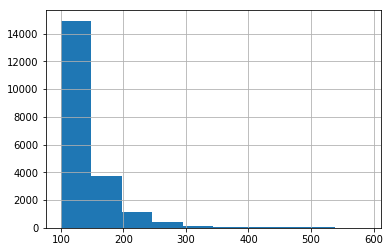

In [12]:
train.fare_amount[(train.fare_amount > 100) & (train.fare_amount < 600)].hist()

In [13]:
train = train[(train.fare_amount >= 2.5) & (train.fare_amount < 300) & \
              (train.pickup_latitude > 40.5) & (train.pickup_latitude < 41.75) & \
              (train.pickup_longitude > -74.3) & (train.pickup_longitude < -72.96) & \
              (train.dropoff_latitude > 40.5) & (train.dropoff_latitude < 41.75) & \
              (train.dropoff_longitude > -74.3) & (train.dropoff_longitude < -72.96)]

## Splitting

I'll split the training set into train/dev sets. I do this before feature engineering since I'll be using certain statistics from the training set to create features.

In [14]:
np.random.seed(5452)
train, dev = train_test_split(train, test_size=.01)

## Feature Engineering

Next, I'll create some additional features.

### Location Distribution

By visualizing a small subset of the data, we can see that most rides start and/or end in Manhattan.

In [15]:
hmap = folium.Map(location=[40.779740, -73.967563], zoom_start=11)
hmap.add_child(HeatMap(train[['pickup_latitude', 'pickup_longitude']].head(10000).values, radius=15))

In [16]:
hmap = folium.Map(location=[40.779740, -73.967563], zoom_start=11)
hmap.add_child(HeatMap(train[['dropoff_latitude', 'dropoff_longitude']].head(10000).values, radius=15))

### Datetime

From the `pickup_datetime`, I'll extract year, month, day of week, and hour. I expect that these will have predictive value since different times of day, days of the week, etc, will have different traffic patterns.

In [17]:
%%time
def add_datetime_features(df):
    '''Adds year/week/dow/hour features to `df` from the `pickup_datetime` column'''
    df.pickup_datetime = pd.to_datetime(
        df.pickup_datetime, utc=True, infer_datetime_format=True) \
        .dt.tz_convert('US/Eastern')
    df['year'] = df.pickup_datetime.dt.year
    df['month'] = df.pickup_datetime.dt.month
    df['dow'] = df.pickup_datetime.dt.dayofweek
    df['hour'] = df.pickup_datetime.dt.hour

add_datetime_features(test)
add_datetime_features(train)
add_datetime_features(dev)

CPU times: user 6min 20s, sys: 6.94 s, total: 6min 27s
Wall time: 6min 26s


### Pickup and Dropoff Buckets

While using the latitude and longitude directly as features would make sense for certain models (such as tree based models that can effectively bucket the coordinates), other models would not be able to learn at all (such as linear regression). Because of this, I will create categorical coordinate bucket features based on quantiles in the training set. I am particularly interested in experimenting with these as embedding features in a neural network model.

In [18]:
latitude_quantiles = (pd.concat([train.pickup_latitude, train.dropoff_latitude])
                      .quantile(np.arange(0, 1.1, .1)))
longitude_quantiles = (pd.concat([train.pickup_longitude, train.dropoff_longitude])
                       .quantile(np.arange(0, 1.1, .1)))
labels = list(map(str, range(latitude_quantiles.size - 1)))

def add_coordinate_quantiles(df):
    '''Adds coordinate quantile features to `df`'''
    df['pickup_latitude_quantile'] = pd.cut(
        df.pickup_latitude, latitude_quantiles, right=True,
        include_lowest=True, labels=labels)
    df['dropoff_latitude_quantile'] = pd.cut(
        df.dropoff_latitude, latitude_quantiles, right=True,
        include_lowest=True, labels=labels)
    df['pickup_longitude_quantile'] = pd.cut(
        df.pickup_longitude, longitude_quantiles, right=True,
        include_lowest=True, labels=labels)
    df['dropoff_longitude_quantile'] = pd.cut(
        df.dropoff_longitude, longitude_quantiles, right=True,
        include_lowest=True, labels=labels)

add_coordinate_quantiles(test)
add_coordinate_quantiles(train)
add_coordinate_quantiles(dev)

### Airport Features

JFK to/from Manhattan is a fixed fare ride and rides to Newark incur a surcharge, so I'll include these as features. LaGuardia is a normal metered fare, but I'll still include this in case I want to experiment.

In [19]:
def add_airport_features(df):
    '''Adds features'''
    airports = [
        ('jfk', 1500, 40.644166, -73.782222),
        ('lga', 1500, 40.774152, -73.872236),
        ('ewr', 1000, 40.690839, -74.178096)
    ]
    for code, radius, lat, lon in airports:
        df['pickup_distance_to_' + code] = haversine(
            lat, lon, df['pickup_latitude'], df['pickup_longitude'])
        df['pickup_' + code] = (df['pickup_distance_to_' + code] < radius).astype('int')
        df['dropoff_distance_to_' + code] = haversine(
            lat, lon, df['dropoff_latitude'], df['dropoff_longitude'])
        df['dropoff_' + code] = (df['dropoff_distance_to_' + code] < radius).astype('int')

add_airport_features(test)
add_airport_features(train)
add_airport_features(dev)

### Summary

`libosrm` returns a summary string with two roads comma separated, so I'll split these into two separate columns. Also, I'll compute and save frequency numbers for each component since I'll likely want to restrict the vocabulary when training models.

In [20]:
%%time
def add_summary_features(df):
    df['summary1'], df['summary2'] = df.summary.str.split(', ', 1).str
    df.summary1.fillna('', inplace=True)
    df.summary2.fillna('', inplace=True)

add_summary_features(train)
add_summary_features(test)
add_summary_features(dev)

CPU times: user 3min 57s, sys: 12.2 s, total: 4min 9s
Wall time: 4min 8s


In [21]:
s_counts = train.summary.value_counts() / train.shape[0]
s1_counts = train.summary1.value_counts() / train.shape[0]
s2_counts = train.summary2.value_counts() / train.shape[0]

In [22]:
s_counts.name = 'freq'
s1_counts.name = 'freq'
s2_counts.name = 'freq'
s_counts.to_csv('data/summary_freq.csv', header=True, index_label='label')
s1_counts.to_csv('data/summary1_freq.csv', header=True, index_label='label')
s2_counts.to_csv('data/summary2_freq.csv', header=True, index_label='label')

### Bearing

The direction of the ride could also provide a signal especially combined with time of day.

In [23]:
def bearing(lat1, lon1, lat2, lon2, bucket=False):
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
    dlon = np.radians(lon2 - lon1)
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) \
        * np.cos(lat2) * np.cos(dlon))
    initial_bearing = np.degrees(np.arctan2(x, y))
    compass_bearing = (initial_bearing + 360) % 360
    if bucket:
        bucket_bearing = pd.cut(
            compass_bearing, bins=16, labels=list(range(1, 16)) + [0])
        bucket_labels = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
        bucket_lookup = {i: bucket_labels[np.int(np.floor(i/2))] for i in range(16)}
        return bucket_bearing.apply(lambda x: bucket_lookup[x])
    else:
        return compass_bearing

def add_bearing_features(df):
    df['bearing_degrees'] = bearing(
        df.pickup_latitude, df.pickup_longitude,
        df.dropoff_latitude, df.dropoff_longitude)
    df['bearing_bucket'] = bearing(
        df.pickup_latitude, df.pickup_longitude,
        df.dropoff_latitude, df.dropoff_longitude, bucket=True)
    df.loc[df.same_pickup_dropoff, 'bearing_bucket'] = 'None'

add_bearing_features(test)
add_bearing_features(train)
add_bearing_features(dev)

### Haversine Distance

I already have driving distance computed through `libosrm`, but I'll compute haversine distance as well in case I want to experiment with that dimension. It looks like the `fare_amount` is slightly more highly correlated with `distance` as opposed to `haversine_distance`.

In [24]:
def add_haversine_distance(df):
    df['haversine_distance'] = haversine(
        df['pickup_latitude'], df['pickup_longitude'],
        df['dropoff_latitude'], df['dropoff_longitude'])

add_haversine_distance(test)
add_haversine_distance(train)
add_haversine_distance(dev)

In [25]:
print('distance/fare_amount correlation:', pearsonr(train.distance, train.fare_amount))

distance/fare_amount correlation: (0.83909136, 0.0)


In [26]:
print('haversine_distance/fare_amount correlation:', pearsonr(train.haversine_distance, train.fare_amount))

haversine_distance/fare_amount correlation: (0.8271711, 0.0)


## Save

Finally, I'll save the final files to be easily loadable for training.

In [27]:
# Convert boolean features to int for easier handling downstream.
test['same_pickup_dropoff'] = test.same_pickup_dropoff.astype('int')
train['same_pickup_dropoff'] = train.same_pickup_dropoff.astype('int')
dev['same_pickup_dropoff'] = dev.same_pickup_dropoff.astype('int')

In [28]:
train.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'distance',
       'duration', 'summary', 'same_pickup_dropoff', 'year', 'month', 'dow',
       'hour', 'pickup_latitude_quantile', 'dropoff_latitude_quantile',
       'pickup_longitude_quantile', 'dropoff_longitude_quantile',
       'pickup_distance_to_jfk', 'pickup_jfk', 'dropoff_distance_to_jfk',
       'dropoff_jfk', 'pickup_distance_to_lga', 'pickup_lga',
       'dropoff_distance_to_lga', 'dropoff_lga', 'pickup_distance_to_ewr',
       'pickup_ewr', 'dropoff_distance_to_ewr', 'dropoff_ewr', 'summary1',
       'summary2', 'bearing_degrees', 'bearing_bucket', 'haversine_distance'],
      dtype='object')

In [29]:
test.columns

Index(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'distance',
       'duration', 'summary', 'same_pickup_dropoff', 'year', 'month', 'dow',
       'hour', 'pickup_latitude_quantile', 'dropoff_latitude_quantile',
       'pickup_longitude_quantile', 'dropoff_longitude_quantile',
       'pickup_distance_to_jfk', 'pickup_jfk', 'dropoff_distance_to_jfk',
       'dropoff_jfk', 'pickup_distance_to_lga', 'pickup_lga',
       'dropoff_distance_to_lga', 'dropoff_lga', 'pickup_distance_to_ewr',
       'pickup_ewr', 'dropoff_distance_to_ewr', 'dropoff_ewr', 'summary1',
       'summary2', 'bearing_degrees', 'bearing_bucket', 'haversine_distance'],
      dtype='object')

In [30]:
test.to_csv('data/test.csv', index=False)
train.to_csv('data/train.csv', index=False)
dev.to_csv('data/dev.csv', index=False)

In [31]:
! gsutil cp data/dev.csv gs://nyc-taxi-fare-prediction-data; gsutil cp data/test.csv gs://nyc-taxi-fare-prediction-data; gsutil cp data/train.csv gs://nyc-taxi-fare-prediction-data

Copying file://data/dev.csv [Content-Type=text/csv]...
\ [1 files][135.0 MiB/135.0 MiB]                                                
Operation completed over 1 objects/135.0 MiB.                                    
Copying file://data/test.csv [Content-Type=text/csv]...
/ [1 files][  2.7 MiB/  2.7 MiB]                                                
Operation completed over 1 objects/2.7 MiB.                                      
Copying file://data/train.csv [Content-Type=text/csv]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod install